# Single Objective Optimization runs of EnergyScope-LCA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from energyscope.models import Model
from energyscope.energyscope import Energyscope
from energyscope.result import postprocessing
from utils import *
from new_plots import plot_sankey
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [39]:
save_results = False

In [4]:
N_capita_2050 = 9.9e6 # estimated number of inhabitants in Quebec in 2050 (https://statistique.quebec.ca/fr/document/projections-de-population-le-quebec/publication/population-observee-projetee-scenario)

In [5]:
N_capita_2021 = 8.57e6 # observed number of people in Quebec in 2021 (https://statistique.quebec.ca/fr/document/projections-de-population-le-quebec/publication/population-observee-projetee-scenario)

In [6]:
path_inputs = '../01_Notebooks/Data/'
path_model = '../02_Model/'
path_results = '../03_Results/LCA/'

In [7]:
# AMPL licence 
path_to_ampl_licence = r'C:\Users\matth\ampl' # path to your AMPL licence file
os.environ['PATH'] = path_to_ampl_licence+':'+os.environ['PATH']

In [8]:
res_lcia_max_2020 = pd.read_csv(path_model+'QC_techs_lca_2020_max.csv')
impact_scores_2020 = pd.read_csv(path_results+'2020/impact_scores.csv')
impact_scores_2020_direct = pd.read_csv(path_results+'2020/impact_scores_direct_emissions.csv')
res_lcia_max_2050 = pd.read_csv(path_model+'QC_techs_lca_2050_max.csv')
impact_scores_2050 = pd.read_csv(path_results+'2050/impact_scores.csv')
impact_scores_2050_direct = pd.read_csv(path_results+'2050/impact_scores_direct_emissions.csv')

In [9]:
# from [impact / kW(h) or pkm(/h) or tkm(/h)] to [impact / GW(h) or Mpkm(/h) or Mtkm(/h)]
impact_scores_2020.Value = impact_scores_2020.Value * 1e6 
impact_scores_2050.Value = impact_scores_2050.Value * 1e6
impact_scores_2020_direct.Value = impact_scores_2020_direct.Value * 1e6 
impact_scores_2050_direct.Value = impact_scores_2050_direct.Value * 1e6

In [10]:
# Define the solver options
# solver_options = {
#     'solver': 'cplex',
#     'presolve_eps': 5e-9,
#     'presolve_fixeps': 7e-10,
#     'mipgap': 1e-10,
#     'display_eps': 1e-10,
#     'omit_zero_rows': 1,
#     'omit_zero_cols': 1,
#     'show_stats': 1,
#     'solver_msg': 1,
#     'cplex_options': 'integrality=5e-7'
# }

# Define the solver options
solver_options = {
    'solver': 'gurobi',
    'solver_msg': 0,
}

In [11]:
def run_model(validation=False, year=2050):
    
    mod_files=[
        path_model + 'QC_es_main.mod',
        path_model + f'QC_objectives_lca_{year}.mod',
        path_model + 'QC_objective_function.mod',
    ]
    
    dat_files=[
        path_model + f'QC_data_{year}.dat',
        path_model + f'QC_mob_techs_dist_B2D_{year}.dat',
        path_model + f'QC_techs_B2D_{year}.dat',
        path_model + f'QC_mob_params_{year}.dat',
        path_model + f'QC_techs_lca_{year}.dat',
    ]
    
    if validation:
        dat_files.append(path_model + 'QC_validation.dat')
    else:
        dat_files.append(path_model + 'QC_scenarios.dat')
    
    # Initialize the QC model with .mod and .dat files
    model = Model(mod_files=mod_files, dat_files=dat_files)
    
    # Initialize the EnergyScope model
    es = Energyscope(model=model, solver_options=solver_options)
    
    # Solve the model and get results
    res = postprocessing(es.calc())
    
    return res

## Runs and results

In [12]:
list_results = []

for soo in ['Reference', 'TotalCost', 'TotalLCIA_m_CCS', 'TotalLCIA_TTHH', 'TotalLCIA_TTEQ']:
    
    if soo == 'Reference':
        obj = 'TotalCost'
        year = 2020
        validation = True
        impact_scores = impact_scores_2020
        impact_scores_direct = impact_scores_2020_direct
        N_capita = N_capita_2021
    else:
        obj = soo
        year = 2050
        validation = False
        impact_scores = impact_scores_2050
        impact_scores_direct = impact_scores_2050_direct
        N_capita = N_capita_2050
    
    with open(path_model + 'QC_objective_function.mod', 'w') as f:
        f.write(f'minimize obj: {obj};')
    results = run_model(year=year, validation=validation)
    
    print(f"\n##### OBJECTIVE FUNCTION - {soo} #####")
    df_f_mult, df_annual_prod, df_annual_res = get_impact_scores(
        impact_category=[
            ('IMPACT World+ Midpoint 2.1_regionalized for ecoinvent v3.10', 'Midpoint', 'Climate change, short term'),
            ('IMPACT World+ Damage 2.1_regionalized for ecoinvent v3.10', 'Ecosystem quality', 'Total ecosystem quality'),
            ('IMPACT World+ Damage 2.1_regionalized for ecoinvent v3.10', 'Human health', 'Total human health'),
        ],
        df_impact_scores=impact_scores,
        df_results=results,
    )
    
    df_annual_prod_direct  = get_impact_scores(
        impact_category=[
            ('IMPACT World+ Midpoint 2.1_regionalized for ecoinvent v3.10', 'Midpoint', 'Climate change, short term'),
            ('IMPACT World+ Damage 2.1_regionalized for ecoinvent v3.10', 'Ecosystem quality', 'Total ecosystem quality'),
            ('IMPACT World+ Damage 2.1_regionalized for ecoinvent v3.10', 'Human health', 'Total human health'),
        ],
        df_impact_scores=impact_scores_direct,
        df_results=results,
        assessment_type='direct emissions',
    )
    
    print('\n##### TOTAL COST #####')
    tc, mc, oc, ic = get_life_cycle_phase_cost_per_capita(
        df_results=results,
        N_capita=N_capita,
    )
    
    print('\n##### CLIMATE CHANGE, SHORT TERM #####')
    ccst_tot, ccst_op, ccst_constr, ccst_res, ccst_direct = get_life_cycle_phase_impact_per_capita(
        df_f_mult=df_f_mult,
        df_annual_prod=df_annual_prod,
        df_annual_res=df_annual_res,
        df_annual_prod_direct=df_annual_prod_direct,
        impact_category='Climate change, short term',
        N_capita=N_capita,
    )
    
    print('\n##### DIRECT CARBON EMISSIONS #####')
    tgwp = results.variables['TotalGWP'].TotalGWP.iloc[0] * 1e3 / N_capita  # [t CO2 / cap]
    print(f"Total GWP per capita from EnergyScope's carbon layers: {tgwp:.2f} t CO2 / capita")
    print(f"Total GWP per capita from direct emissions: {ccst_direct:.2f} t CO2-eq / capita")
    
    print('\n##### HUMAN HEALTH #####')
    tthh_tot, tthh_op, tthh_constr, tthh_res, tthh_direct = get_life_cycle_phase_impact_per_capita(
        df_f_mult=df_f_mult,
        df_annual_prod=df_annual_prod,
        df_annual_res=df_annual_res,
        df_annual_prod_direct=df_annual_prod_direct,
        impact_category='Total human health',
        N_capita=N_capita,
    )
    
    print('\n##### ECOSYSTEM QUALITY #####')
    tteq_tot, tteq_op, tteq_constr, tteq_res, tteq_direct = get_life_cycle_phase_impact_per_capita(
        df_f_mult=df_f_mult,
        df_annual_prod=df_annual_prod,
        df_annual_res=df_annual_res,
        df_annual_prod_direct=df_annual_prod_direct,
        impact_category='Total ecosystem quality',
        N_capita=N_capita,
    )
    
    # result tables
    results_name = soo.replace('Total','').lower()
    df_annual_prod_contrib = get_contribution_df(df_annual_prod, ['Climate change, short term', 'Total human health', 'Total ecosystem quality'])
    df_annual_res_contrib = get_contribution_df(df_annual_res, ['Climate change, short term', 'Total human health', 'Total ecosystem quality'])
    df_f_mult_contrib = get_contribution_df(df_f_mult, ['Climate change, short term', 'Total human health', 'Total ecosystem quality'])
    
    if save_results:
        df_annual_prod_contrib.to_csv(f'../03_Results/Tables/soo_{results_name}/annual_production_contributions.csv', index=False)
        df_annual_res_contrib.to_csv(f'../03_Results/Tables/soo_{results_name}/annual_resource_contributions.csv', index=False)
        df_f_mult_contrib.to_csv(f'../03_Results/Tables/soo_{results_name}/installed_capacities_contributions.csv', index=False)
    
    # sankey 
    fig = plot_sankey(results)
    
    if save_results:
        fig.write_html(f'../03_Results/Figures/soo_sankey_{results_name}.html')
    
    # save results in list
    list_results.extend([
        [soo, 'Total cost [CAD/cap]', tc, mc, ic, oc, None],
        [soo, 'Climate change (short term) [t CO2-eq/cap]', ccst_tot, ccst_op, ccst_constr, ccst_res, ccst_direct],
        [soo, 'Total human health [DALY/cap]', tthh_tot, tthh_op, tthh_constr, tthh_res, tthh_direct],
        [soo, 'Total ecosystem quality [PDF.m2.yr/cap]', tteq_tot, tteq_op, tteq_constr, tteq_res, tteq_direct],
    ])

columns = ['Objective function', 'Metric', 'Total', 'Operation', 'Construction', 'Resources', 'Direct emissions (included in operation)']
df_results = pd.DataFrame(data=list_results, columns=columns)

Gurobi 12.0.0: 
##### OBJECTIVE FUNCTION - Reference #####

##### TOTAL COST #####
Total cost: 8772 CAD / cap / year
Maintenance cost ratio: 23.799 %
Operation cost ratio: 30.973 %
Annualized investment cost ratio: 45.228 %

##### CLIMATE CHANGE, SHORT TERM #####
Life-cycle carbon footprint per capita: 10.39 t CO2-eq / capita
Percentage due to operation: 68.484 %
Including direct emissions: 52.199 %
Percentage due to construction: 9.417 %
Percentage due to resource: 22.098 %

##### DIRECT CARBON EMISSIONS #####
Total GWP per capita from EnergyScope's carbon layers: 7.66 t CO2 / capita
Total GWP per capita from direct emissions: 5.42 t CO2-eq / capita

##### HUMAN HEALTH #####
Life-cycle carbon footprint per capita: 0.127 DALY / capita
Percentage due to operation: 79.382 %
Including direct emissions: 67.506 %
Percentage due to construction: 6.954 %
Percentage due to resource: 13.664 %

##### ECOSYSTEM QUALITY #####
Life-cycle carbon footprint per capita: 10010.906 PDF.m2.yr / capita
Per

## Summary tables

In [13]:
df_results

,Objective function,Metric,Total,Operation,Construction,Resources,Direct emissions (included in operation)
0,Reference,Total cost [CAD/cap],8772.114246,2087.685619,3967.410249,2717.018378,NaN
1,Reference,Climate change (short term) [t CO2-eq/cap],10.389527,7.115201,0.978403,2.295924,5.423179
2,Reference,Total human health [DALY/cap],0.127331,0.101078,0.008855,0.017398,0.085956
3,Reference,Total ecosystem quality [PDF.m2.yr/cap],10010.905792,6448.398962,1137.737133,2424.769697,4720.381064
4,TotalCost,Total cost [CAD/cap],4724.570034,1343.801609,3236.189437,144.578989,NaN
5,TotalCost,Climate change (short term) [t CO2-eq/cap],5.057678,2.908715,1.551803,0.597160,1.382027
6,TotalCost,Total human health [DALY/cap],0.044177,0.026666,0.013769,0.003743,0.012981
7,TotalCost,Total ecosystem quality [PDF.m2.yr/cap],6680.135212,3443.953206,1872.581920,1363.600087,1213.767725
8,TotalLCIA_m_CCS,Total cost [CAD/cap],8453.818395,1732.160733,6351.033460,370.624202,NaN
9,TotalLCIA_m_CCS,Climate change (short term) [t CO2-eq/cap],2.121231,1.093305,0.928801,0.099125,0.469908


In [14]:
if save_results:
    df_results.to_csv('../03_Results/Tables/soo_full_table.csv', index=False)

In [15]:
summary_table = df_results[['Objective function', 'Metric', 'Total']].pivot_table(index='Objective function', columns='Metric', values='Total').reset_index()

In [16]:
if save_results:
    summary_table.to_csv('../03_Results/Tables/soo_summary_table.csv', index=False)

## Plots

### Bar plot

In [17]:
def normalize_df_results(row, col, df_results=df_results):
    metric = row['Metric']
    obj = row['Objective function']
    if obj == 'Reference' and col == 'Total':
        return 100
    else:
        return 100 * row[col] / df_results[(df_results['Objective function'] == 'Reference') & (df_results['Metric'] == metric)]['Total'].values[0]

In [18]:
df_results_normalized = df_results.copy()
df_results_normalized['Operation'] = df_results_normalized.apply(normalize_df_results, args=('Operation',), axis=1)
df_results_normalized['Construction'] = df_results_normalized.apply(normalize_df_results, args=('Construction',), axis=1)
df_results_normalized['Resources'] = df_results_normalized.apply(normalize_df_results, args=('Resources',), axis=1)
df_results_normalized['Total'] = df_results_normalized.apply(normalize_df_results, args=('Total',), axis=1)
df_results_normalized['Direct emissions (included in operation)'] = df_results_normalized.apply(normalize_df_results, args=('Direct emissions (included in operation)',), axis=1)
df_results_normalized['Metric'] = df_results_normalized['Metric'].apply(lambda x: x.split(' [')[0])

In [19]:
obj_new_names = {
    'Reference': 'Reference',
    'TotalCost': 'Total cost',
    'TotalLCIA_m_CCS': 'Climate change (short term)',
    'TotalLCIA_TTHH': 'Total human health',
    'TotalLCIA_TTEQ': 'Total ecosystem quality',
}
df_results_normalized['Objective function'] = df_results_normalized['Objective function'].apply(lambda x: obj_new_names[x])

In [20]:
df_results_normalized.drop(df_results_normalized[df_results_normalized['Objective function'] == 'Reference'].index, inplace=True)

In [21]:
data = []
for obj in df_results_normalized['Objective function'].unique():
    data.append(go.Bar(
        name=obj, 
        x=df_results_normalized[df_results_normalized['Objective function'] == obj]['Metric'], 
        y=df_results_normalized[df_results_normalized['Objective function'] == obj]['Total'],
    ))

In [40]:
fig = go.Figure(data)
fig.update_layout(
    barmode='group', 
    template='plotly_white', 
    legend_title_text='Objective function',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.98,
    )
)
fig.update_yaxes(title_text='Cost or impact relative to 2021 [%]')
fig.show()

if save_results:
    fig.write_html('../03_Results/Figures/soo_relative_bar_plot.html')

In [41]:
df_results_normalized_melted = df_results_normalized[['Objective function', 'Metric', 'Construction', 'Operation', 'Resources']].melt(id_vars=['Objective function', 'Metric'], value_vars=['Construction', 'Operation', 'Resources'])

In [42]:
for obj in df_results_normalized_melted['Objective function'].unique():
    fig = px.bar(
        df_results_normalized_melted[df_results_normalized_melted['Metric'] == obj], 
        x='Objective function', 
        y='value',
        color='Objective function',
        pattern_shape='variable',
        pattern_shape_sequence=['', '/', '.'],
    )
    fig.update_xaxes(title_text='')
    fig.update_layout(showlegend=False, template='plotly_white')
    fig.update_yaxes(title_text=f'{obj} relative to 2021 [%]')
    
    fig.show()
    
    if save_results:
        fig.write_html('../03_Results/Figures/soo_relative_bar_plot_w_phases_contrib_for_'+obj+'.html')

### Scatter plot

In [29]:
validation_tc = summary_table[summary_table['Objective function'] == 'Reference']['Total cost [CAD/cap]'].values[0]
validation_ccst_tot = summary_table[summary_table['Objective function'] == 'Reference']['Climate change (short term) [t CO2-eq/cap]'].values[0]
validation_tthh_tot = summary_table[summary_table['Objective function'] == 'Reference']['Total human health [DALY/cap]'].values[0]
validation_tteq_tot = summary_table[summary_table['Objective function'] == 'Reference']['Total ecosystem quality [PDF.m2.yr/cap]'].values[0]

In [31]:
# Normalizing with respect to 2020 reference 
summary_table['Total cost [CAD/cap]'] = summary_table['Total cost [CAD/cap]'] / validation_tc
summary_table['Climate change (short term) impact [t CO2-eq/cap]'] = summary_table['Climate change (short term) [t CO2-eq/cap]'] / validation_ccst_tot
summary_table['Total human health [DALY/cap]'] = summary_table['Total human health [DALY/cap]'] / validation_tthh_tot
summary_table['Total ecosystem quality [PDF.m2.yr/cap]'] = summary_table['Total ecosystem quality [PDF.m2.yr/cap]'] / validation_tteq_tot

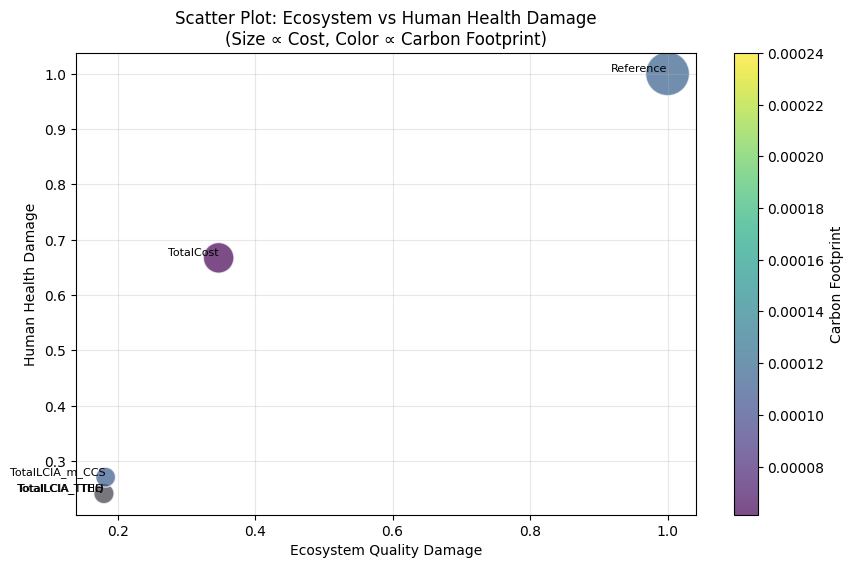

In [32]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=summary_table['Total human health [DALY/cap]'],
    y=summary_table['Total ecosystem quality [PDF.m2.yr/cap]'],
    c=summary_table['Total cost [CAD/cap]'],
    s=summary_table['Climate change (short term) impact [t CO2-eq/cap]']*1000,
    cmap='viridis',
    alpha=0.7,
    edgecolors="w",
)

# Add text labels for each point
for i in range(len(summary_table)):
    plt.text(
        x=summary_table['Total human health [DALY/cap]'][i],
        y=summary_table["Total ecosystem quality [PDF.m2.yr/cap]"][i],
        s=summary_table["Objective function"][i],
        fontsize=8,  # Font size for labels
        ha="right",  # Horizontal alignment
        va="bottom",  # Vertical alignment
        color="black",  # Text color
    )

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Carbon Footprint")

# Labels and title
plt.xlabel("Ecosystem Quality Damage")
plt.ylabel("Human Health Damage")
plt.title("Scatter Plot: Ecosystem vs Human Health Damage\n(Size ∝ Cost, Color ∝ Carbon Footprint)")

# Show the plot
plt.grid(True, alpha=0.3)
plt.show()